# MNIST Classifying with Least Squares

We will classify the image data in MNIST (predicting 10 labels, numbers 0-9) with a naive least squares approach. Each of the training and test images is $28 \times 28$ pixels so we can turn each of those into a $784 \times 1$ column vector. We have 60,000 training images to train our classifier. We can write the optimization problem as follows. 

\begin{gather}
\min_{W,b} \frac{1}{2} \left\Vert \bf{WY}+be^T-\bf{C} \right\Vert
\end{gather}

In [1]:
import struct
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir("/c/Users/thsiao3/Documents/emory_class/MATH789/hw2")

Need some helper functions to 1) read in the MNIST data as a numpy 3D array (rows, columns, values) and then 2) plot each image on the grid

In [42]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def plot_mnist(pixels):
    plt.gray()
    xaxis = np.tile(np.linspace(0,1,num=28),28)
    yaxis = np.repeat(np.linspace(1,0,num=28),28)
    # Way to remove the tick marks
    plt.xticks([])
    plt.yticks([])
    plt.scatter(xaxis, yaxis, c=pixels, marker="s",s=190)

Below is some data preprocessing. We want to first reshape each of our 60000 $28 \times 28$ training images into a column vector. 
Then, we want to add a bias vector to the weight matrix we are estimating. This means we must add a constant vector (all ones) as an 
additional "feature" to our training and test data, in addition to the 784 pixels. 

In [3]:
train_images = read_idx("train-images-idx3-ubyte")
train_labels = read_idx("train-labels-idx1-ubyte")
test_images = read_idx("t10k-images-idx3-ubyte")
test_labels = read_idx("t10k-labels-idx1-ubyte")

# Grab dimensions
n_c = len(np.unique(test_labels))
n_train = train_images.shape[0]
n_test = test_images.shape[0]

# Turn each of the 60000 flattened into an array. so 2D array
train_data = np.reshape(train_images, (n_train, 28**2))
test_data = np.reshape(test_images, (n_test, 28**2))

# Add the biases vector to train and test data
ones_train = np.ones((n_train,1))
ones_test = np.ones((n_test, 1))
train_data = np.hstack((ones_train, train_data))
test_data = np.hstack((ones_test, test_data))

Lets visualize some of the training images to see what the MNIST data numbers look like

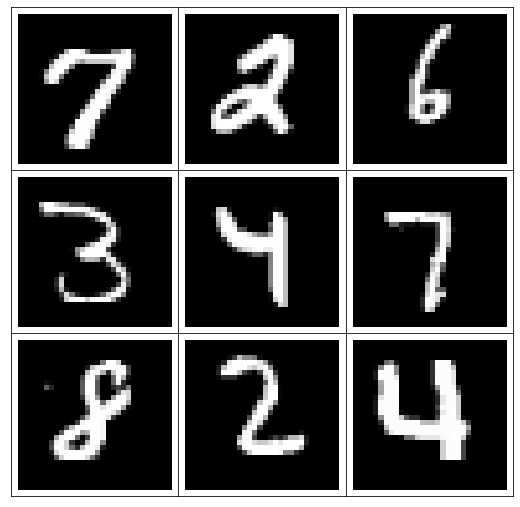

In [30]:
obs_index = np.random.randint(0,60000,9)
f = plt.figure(figsize=(9, 9))
for k in range(9):
    ax = f.add_subplot(3, 3, k+1)
    plot_mnist(train_data[obs_index[k],1:])
plt.subplots_adjust(wspace=0, hspace=0)

The least squares method is very straightforward. Unfortunately, our training data matrix is singular. Taking the SVD can shed more light on the problem.

In [32]:
Y = train_data
C = np.zeros((n_c, n_train))
for i in np.arange(n_train):
    C[train_labels[i], i] = 1

There are infinite solutions to our problem. However, the numpy method lstsq gives us a solution that turns out to be the solution that satisfies the equation, with a norm less than or equal to all other solutions. This is the same solution that the pseudo inverse would give us.

In [60]:
# Weights and biases matrix (Betas in statistical literature)
W = np.linalg.lstsq(Y, C.T, rcond=None)[0]
C_train = train_data @ W
C_test = test_data @ W
train_predict = np.apply_along_axis(func1d=np.argmax, axis=1, arr=C_train)
test_predict = np.apply_along_axis(func1d=np.argmax, axis=1, arr=C_test)

Training and test accuracies are below

In [64]:
test_acc = np.round(np.mean(test_predict == test_labels), 4)
train_acc = np.round(np.mean(train_predict == train_labels), 4)
print("Training accuracy: {} \nTest accuracy: {}".format(train_acc, test_acc))

Training accuracy: 0.8577 
Test accuracy: 0.8603


We can visualize the columns of the $\bf{W}$ matrix as images as well. Our matrix is currently 785 x 10, so the rows
represent the features/pixels (along with the bias vector) and the columns represent the digits to be classified, 0-9. We want to visualize the 784 features representing the pixels as an image.

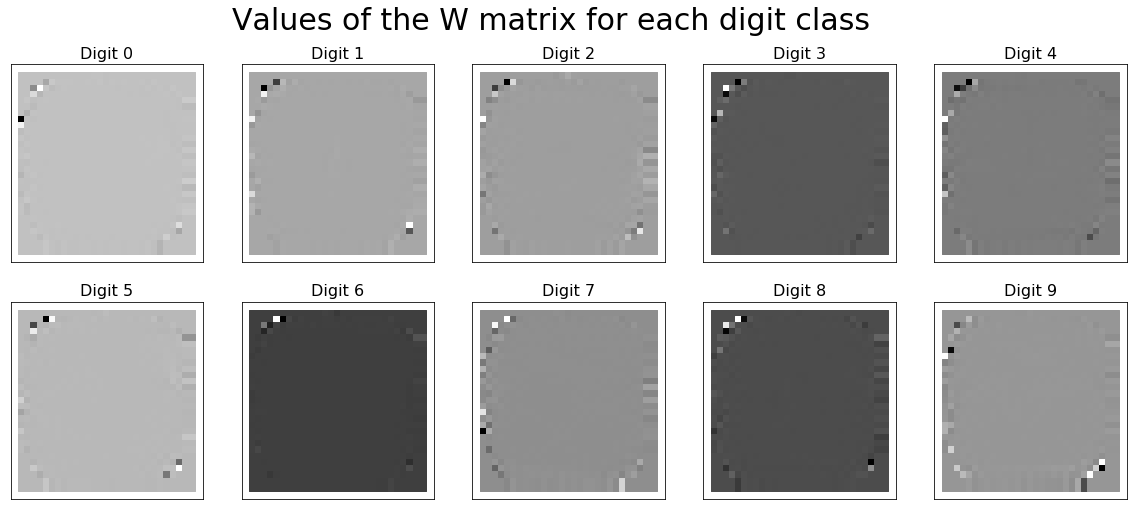

In [56]:
f = plt.figure(figsize=(20, 8))
f.suptitle('Values of the W matrix for each digit class', fontsize=30)
for k in range(10):
    ax = f.add_subplot(2, 5, k+1)
    plot_mnist(W[:,k][1:])
    ax.set_title("Digit {}".format(k), fontsize=16)

This doesn't really look like anything meaningful. It looks like our classifier picked up on some random signals that we certainly 
would not associate with handwritten digits. 